In [1]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 200
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat, get_diff_volcano
from homer_preprocessing import read_annotated_peaks, import_homer_diffpeak, pull_comparisons_get_diff
from gene_expression_plots import survey_strain_amln_gene_exp, survey_strain_ccl4_gene_exp

In [2]:
dataDirectory = ''
workingDirectory = '/home/h1bennet/strains/results/01_Strains_AMLNtoControl_H3K27Ac/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

# Process for motif calling with Maggie

For motif calling its unclear whether it would be ideal to take all peaks activated in C57 compared to any other strain and look for motif enrichment or whether it would be better to look at motifs only in a pairwise fashion. I probably lean towards looking at any peak activated in C57 since they should be enriched for strain specific motifs.

In [3]:
if not os.path.isdir('./motif_calling/'):
    os.mkdir('./motif_calling/')

Ty pointed out that running annotatePeaks.pl on a peak file adjusts the peak size to what is being annotated :O so we have to pull the original coordinates out of the ATAC file. The ATAC peak file from O'young's pipeline has an average peak size of about 270 so they are a little bigger than the NFR we like for ATAC seq. I'm unsure whether the best thing to do here would be to make them all 200 bp based on the center of the peak or if we should just use the merged peak sizes

In [7]:
atac_peaks = pd.read_csv('./kc_amln_atac_peaks_all.txt', sep='\t', index_col=0)

Make atac peak file with 200bp peaks set on center of current peak (rounding down if fractional center)

In [8]:
new_start = []
new_end = []
for index, row in atac_peaks.iterrows():
    center = row.start + int(np.floor((row.end - row.start)/2))
    new_start.append(center - 100)
    new_end.append(center + 100)
    
atac_peaks_200bp = atac_peaks.iloc[:, :4].copy(deep=True)
atac_peaks_200bp['start'] = new_start
atac_peaks_200bp['end'] = new_end
atac_peaks_200bp.index.rename('PeakID', inplace=True)

### Extract differential peaks

In [31]:
# set p value and log2fc
padj = 0.05
log2fc = 1

peak_dict_distal = {}

for i in glob.glob('./*diff_output.txt'):
    diff_peak, peaks, peak_mat, peak_mat_quant = import_homer_diffpeak(
        i,
        './ann_norm_kc_amln_atac_peaks_all.txt')
    
    # extract distal peaks only
    diff_peak = diff_peak.loc[np.abs(diff_peak.loc[:, 'Distance to TSS']) >= 3000, :]
    
    # log2fc is in position -3, adj p value is in position -1
    # positive peaks are up in NASH, negative peaks are down in NASH
    act = diff_peak.loc[(diff_peak.iloc[:, -3] >= log2fc) & (diff_peak.iloc[:, -1] < padj), :].index.tolist()
    rep = diff_peak.loc[(diff_peak.iloc[:, -3] <= -log2fc) & (diff_peak.iloc[:, -1] < padj), :].index.tolist()
    
    # write out peaks
    with open(i.split('_')[0]+'_act_peaks_p_'+str(padj)+'_log2fc_'+str(log2fc)+'.txt', 'w') as f:
        f.write('PeakID\n')
        for j in act:
            f.write(j)
        f.close
        
    with open(i.split('_')[0]+'_rep_peaks_p_'+str(padj)+'_log2fc_'+str(log2fc)+'.txt', 'w') as f:
        f.write('PeakID\n')
        for j in rep:
            f.write(j)
        f.close
        
    peak_dict_distal[i.split('_')[0].replace('./','')] = [act, rep]

annotatePeaks all peaks (49106, 31)
getDiffExpression selected transcripts (48031, 25)
annotatePeaks selected peaks (48031, 31)
annotatePeaks all peaks (49106, 31)
getDiffExpression selected transcripts (48031, 25)
annotatePeaks selected peaks (48031, 31)
annotatePeaks all peaks (49106, 31)
getDiffExpression selected transcripts (48031, 25)
annotatePeaks selected peaks (48031, 31)


In [32]:
if not os.path.isdir('./differential_peaks/'):
    os.mkdir('./differential_peaks/')

In [33]:
import itertools
mylist = peak_dict_distal.keys()

# spec_peak_dict_distal = {}
# use pattern to extract cell type
for i, j in itertools.permutations(mylist, r=2):
    print(i, j)
    
    print('Activated peaks distal:')
    print(atac_peaks_200bp.loc[set(peak_dict_distal[i][0]).difference(peak_dict_distal[j][0]), :].shape[0])
    act_filename = './differential_peaks/'+i+'_act_'+j+'_bg_distal.txt'
    atac_peaks_200bp.loc[set(peak_dict_distal[i][0]).difference(peak_dict_distal[j][0]), :].to_csv(act_filename, sep='\t')
    
    
    print('Repressed peaks distal:')
    print(atac_peaks_200bp.loc[set(peak_dict_distal[i][1]).difference(peak_dict_distal[j][1]), :].shape[0])
    act_filename = './differential_peaks/'+i+'_rep_'+j+'_bg_distal.txt'
    atac_peaks_200bp.loc[set(peak_dict_distal[i][1]).difference(peak_dict_distal[j][1]), :].to_csv(act_filename, sep='\t')



C57 aj
Activated peaks distal:
1846
Repressed peaks distal:
1596
C57 balbc
Activated peaks distal:
2508
Repressed peaks distal:
1908
aj C57
Activated peaks distal:
563
Repressed peaks distal:
380
aj balbc
Activated peaks distal:
1208
Repressed peaks distal:
681
balbc C57
Activated peaks distal:
36
Repressed peaks distal:
26
balbc aj
Activated peaks distal:
19
Repressed peaks distal:
15


### Non distal peaks

In [34]:
# set p value and log2fc
padj = 0.05
log2fc = 1

peak_dict = {}

for i in glob.glob('./*diff_output.txt'):
    diff_peak, peaks, peak_mat, peak_mat_quant = import_homer_diffpeak(
        i,
        './ann_norm_kc_amln_atac_peaks_all.txt')
    
    # extract distal peaks only
    # diff_peak = diff_peak.loc[np.abs(diff_peak.loc[:, 'Distance to TSS']) >= 3000, :]
    
    # log2fc is in position -3, adj p value is in position -1
    # positive peaks are up in NASH, negative peaks are down in NASH
    act = diff_peak.loc[(diff_peak.iloc[:, -3] >= log2fc) & (diff_peak.iloc[:, -1] < padj), :].index.tolist()
    rep = diff_peak.loc[(diff_peak.iloc[:, -3] <= -log2fc) & (diff_peak.iloc[:, -1] < padj), :].index.tolist()
    
    # write out peaks
    with open(i.split('_')[0]+'_act_peaks_p_'+str(padj)+'_log2fc_'+str(log2fc)+'.txt', 'w') as f:
        f.write('PeakID\n')
        for j in act:
            f.write(j)
        f.close
        
    with open(i.split('_')[0]+'_rep_peaks_p_'+str(padj)+'_log2fc_'+str(log2fc)+'.txt', 'w') as f:
        f.write('PeakID\n')
        for j in rep:
            f.write(j)
        f.close
        
    peak_dict[i.split('_')[0].replace('./','')] = [act, rep]

annotatePeaks all peaks (49106, 31)
getDiffExpression selected transcripts (48031, 25)
annotatePeaks selected peaks (48031, 31)
annotatePeaks all peaks (49106, 31)
getDiffExpression selected transcripts (48031, 25)
annotatePeaks selected peaks (48031, 31)
annotatePeaks all peaks (49106, 31)
getDiffExpression selected transcripts (48031, 25)
annotatePeaks selected peaks (48031, 31)


In [35]:
import itertools
mylist = peak_dict.keys()

# spec_peak_dict = {}
# use pattern to extract cell type
for i, j in itertools.permutations(mylist, r=2):
    print(i, j)
    
    print('Activated peaks:')
    print(atac_peaks_200bp.loc[set(peak_dict[i][0]).difference(peak_dict[j][0]), :].shape[0])
    act_filename = './differential_peaks/'+i+'_act_'+j+'_bg.txt'
    atac_peaks_200bp.loc[set(peak_dict[i][0]).difference(peak_dict[j][0]), :].to_csv(act_filename, sep='\t')
    
    
    print('Repressed peaks:')
    print(atac_peaks_200bp.loc[set(peak_dict[i][1]).difference(peak_dict[j][1]), :].shape[0])
    act_filename = './differential_peaks/'+i+'_rep_'+j+'_bg.txt'
    atac_peaks_200bp.loc[set(peak_dict[i][1]).difference(peak_dict[j][1]), :].to_csv(act_filename, sep='\t')



C57 aj
Activated peaks:
2242
Repressed peaks:
2025
C57 balbc
Activated peaks:
3075
Repressed peaks:
2454
aj C57
Activated peaks:
731
Repressed peaks:
574
aj balbc
Activated peaks:
1537
Repressed peaks:
979
balbc C57
Activated peaks:
63
Repressed peaks:
55
balbc aj
Activated peaks:
36
Repressed peaks:
31


### Call motifs using homer

In [175]:
%%bash
# delete the existing script file
rm ./findMotifs_homer.sh
# create a script file
touch ./findMotifs_homer.sh

In [176]:
%%bash
for i in ./motif_calling/*act*;
do bg_file=${i/act/bg};
out=${i/.txt/_motifs};
echo "findMotifsGenome.pl $i mm10 $out -bg $bg_file -len 8,10,12,14,16 -size given &" >> ./findMotifs_homer.sh
done

# Process in  Maggie

Here we just want to take peaks that are increased specifically in one strain when compared to another, but i would prefer to do this all in one go so that we can pool our power. Perhaps we can start by doing everything relevant to C57 - this would introduce duplicate peaks which could affect our overall power

To do this part it helps to have some understanding of the diffpeak file that homer puts out... the columns at the end are "group1 vs group2" with p value and log2fold change. The log2fold change here looks like this:  \

$\log2(\frac{group2 tags}{group1 tags})$  

So in this case things that are higher in group 1 will be negative and things that are higher in group 2 will be positive. Since C57 is group 1 in this case it all negative peaks will be up in C57

Extract sequences for maggie

In [3]:
if not os.path.isdir('./differential_fasta/'):
    os.mkdir('./differential_fasta/')

### Activated peaks

In [ ]:
### c57 vs. balb distal
marge extract_sequences -ind BALBCJ -file ./differential_peaks/balbc_act_C57_bg_distal.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/balbc_act_c57_distal_ref.fa
marge extract_sequences -ind C57BL6J -file ./differential_peaks/balbc_act_C57_bg_distal.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/balbc_act_c57_distal_mut.fa

marge extract_sequences -ind C57BL6J -file ./differential_peaks/C57_act_balbc_bg_distal.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/c57_act_balbc_distal_ref.fa
marge extract_sequences -ind BALBCJ -file ./differential_peaks/C57_act_balbc_bg_distal.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/c57_act_balbc_distal_mut.fa


### c57 vs aj distal
marge extract_sequences -ind C57BL6J -file ./differential_peaks/C57_act_aj_bg_distal.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/c57_act_aj_distal_ref.fa
marge extract_sequences -ind AJ -file ./differential_peaks/C57_act_aj_bg_distal.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/c57_act_aj_distal_mut.fa

marge extract_sequences -ind AJ -file ./differential_peaks/aj_act_C57_bg_distal.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/aj_act_c57_distal_ref.fa
marge extract_sequences -ind C57BL6J -file ./differential_peaks/aj_act_C57_bg_distal.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/aj_act_c57_distal_mut.fa


### balb vs. aj distal

marge extract_sequences -ind BALBCJ -file ./differential_peaks/balbc_act_aj_bg_distal.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/balbc_act_aj_distal_ref.fa
marge extract_sequences -ind AJ -file ./differential_peaks/balbc_act_aj_bg_distal.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/balbc_act_aj_distal_mut.fa

marge extract_sequences -ind AJ -file ./differential_peaks/aj_act_balbc_bg_distal.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/aj_act_balbc_distal_ref.fa
marge extract_sequences -ind BALBCJ -file ./differential_peaks/aj_act_balbc_bg_distal.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/aj_act_balbc_distal_mut.fa


In [ ]:
### c57 vs. balb
marge extract_sequences -ind BALBCJ -file ./differential_peaks/balbc_act_C57_bg.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/balbc_act_c57_ref.fa
marge extract_sequences -ind C57BL6J -file ./differential_peaks/balbc_act_C57_bg.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/balbc_act_c57_mut.fa

marge extract_sequences -ind C57BL6J -file ./differential_peaks/C57_act_balbc_bg.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/c57_act_balbc_ref.fa
marge extract_sequences -ind BALBCJ -file ./differential_peaks/C57_act_balbc_bg.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/c57_act_balbc_mut.fa


### c57 vs aj
marge extract_sequences -ind C57BL6J -file ./differential_peaks/C57_act_aj_bg.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/c57_act_aj_ref.fa
marge extract_sequences -ind AJ -file ./differential_peaks/C57_act_aj_bg.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/c57_act_aj_mut.fa

marge extract_sequences -ind AJ -file ./differential_peaks/aj_act_C57_bg.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/aj_act_c57_ref.fa
marge extract_sequences -ind C57BL6J -file ./differential_peaks/aj_act_C57_bg.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/aj_act_c57_mut.fa


### balb vs. aj

marge extract_sequences -ind BALBCJ -file ./differential_peaks/balbc_act_aj_bg.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/balbc_act_aj_ref.fa
marge extract_sequences -ind AJ -file ./differential_peaks/balbc_act_aj_bg.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/balbc_act_aj_mut.fa

marge extract_sequences -ind AJ -file ./differential_peaks/aj_act_balbc_bg.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/aj_act_balbc_ref.fa
marge extract_sequences -ind BALBCJ -file ./differential_peaks/aj_act_balbc_bg.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/aj_act_balbc_mut.fa


# Try running maggie with aggregated peaks

In [6]:
if not os.path.isdir('./maggie_output/'):
    os.mkdir('./maggie_output/')

balbc vs c57

In [ ]:
/home/h1bennet/anaconda3/envs/maggie/bin/python ~/maggie/bin/maggie_fasta_input.py \
./differential_fasta/balbc_act_c57_ref.fa,./differential_fasta/c57_act_balbc_ref.fa \
./differential_fasta/balbc_act_c57_mut.fa,./differential_fasta/c57_act_balbc_mut.fa \
-o ./maggie_output/c57_vs_balbc/ \
-p 8

In [ ]:
/home/h1bennet/anaconda3/envs/maggie/bin/python ~/maggie/bin/maggie_fasta_input.py \
./differential_fasta/balbc_act_c57_distal_ref.fa,./differential_fasta/c57_act_balbc_distal_ref.fa \
./differential_fasta/balbc_act_c57_distal_mut.fa,./differential_fasta/c57_act_balbc_distal_mut.fa \
-o ./maggie_output/c57_vs_balbc_distal/ \
-p 8

aj vs C57

In [ ]:
/home/h1bennet/anaconda3/envs/maggie/bin/python ~/maggie/bin/maggie_fasta_input.py \
./differential_fasta/aj_act_c57_ref.fa,./differential_fasta/c57_act_aj_ref.fa \
./differential_fasta/aj_act_c57_mut.fa,./differential_fasta/c57_act_aj_mut.fa \
-o ./maggie_output/c57_vs_aj/ \
-p 8

In [ ]:
/home/h1bennet/anaconda3/envs/maggie/bin/python ~/maggie/bin/maggie_fasta_input.py \
./differential_fasta/aj_act_c57_distal_ref.fa,./differential_fasta/c57_act_aj_distal_ref.fa \
./differential_fasta/aj_act_c57_distal_mut.fa,./differential_fasta/c57_act_aj_distal_mut.fa \
-o ./maggie_output/c57_vs_aj_distal/ \
-p 8

balb vs aj

In [ ]:
/home/h1bennet/anaconda3/envs/maggie/bin/python ~/maggie/bin/maggie_fasta_input.py \
./differential_fasta/balbc_act_aj_ref.fa,./differential_fasta/aj_act_balbc_ref.fa \
./differential_fasta/balbc_act_aj_mut.fa,./differential_fasta/aj_act_balbc_mut.fa \
-o ./maggie_output/balb_vs_aj/ \
-p 8

In [ ]:
/home/h1bennet/anaconda3/envs/maggie/bin/python ~/maggie/bin/maggie_fasta_input.py \
./differential_fasta/balbc_act_aj_distal_ref.fa,./differential_fasta/aj_act_balbc_distal_ref.fa \
./differential_fasta/balbc_act_aj_distal_mut.fa,./differential_fasta/aj_act_balbc_distal_mut.fa \
-o ./maggie_output/balb_vs_aj_distal/ \
-p 8

all comparisons

In [ ]:
/home/h1bennet/anaconda3/envs/maggie/bin/python ~/maggie/bin/maggie_fasta_input.py \
./differential_fasta/balbc_act_c57_ref.fa,./differential_fasta/c57_act_balbc_ref.fa,\
./differential_fasta/aj_act_c57_ref.fa,./differential_fasta/c57_act_aj_ref.fa,\
./differential_fasta/balbc_act_aj_ref.fa,./differential_fasta/aj_act_balbc_ref.fa \
./differential_fasta/balbc_act_c57_mut.fa,./differential_fasta/c57_act_balbc_mut.fa,\
./differential_fasta/aj_act_c57_mut.fa,./differential_fasta/c57_act_aj_mut.fa,\
./differential_fasta/balbc_act_aj_mut.fa,./differential_fasta/aj_act_balbc_mut.fa \
-o ./maggie_output/all/ \
-p 8

In [ ]:
/home/h1bennet/anaconda3/envs/maggie/bin/python ~/maggie/bin/maggie_fasta_input.py \
./differential_fasta/balbc_act_c57_distal_ref.fa,./differential_fasta/c57_act_balbc_distal_ref.fa,\
./differential_fasta/aj_act_c57_distal_ref.fa,./differential_fasta/c57_act_aj_distal_ref.fa,\
./differential_fasta/balbc_act_aj_distal_ref.fa,./differential_fasta/aj_act_balbc_distal_ref.fa \
./differential_fasta/balbc_act_c57_distal_mut.fa,./differential_fasta/c57_act_balbc_distal_mut.fa,\
./differential_fasta/aj_act_c57_distal_mut.fa,./differential_fasta/c57_act_aj_distal_mut.fa,\
./differential_fasta/balbc_act_aj_distal_mut.fa,./differential_fasta/aj_act_balbc_distal_mut.fa \
-o ./maggie_output/all_distal/ \
-p 8

### Repressed peaks

In [ ]:
### c57 vs. balb distal
marge extract_sequences -ind BALBCJ -file ./differential_peaks/balbc_rep_C57_bg_distal.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/balbc_rep_c57_distal_ref.fa
marge extract_sequences -ind C57BL6J -file ./differential_peaks/balbc_rep_C57_bg_distal.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/balbc_rep_c57_distal_mut.fa

marge extract_sequences -ind C57BL6J -file ./differential_peaks/C57_rep_balbc_bg_distal.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/c57_rep_balbc_distal_ref.fa
marge extract_sequences -ind BALBCJ -file ./differential_peaks/C57_rep_balbc_bg_distal.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/c57_rep_balbc_distal_mut.fa


### c57 vs aj distal
marge extract_sequences -ind C57BL6J -file ./differential_peaks/C57_rep_aj_bg_distal.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/c57_rep_aj_distal_ref.fa
marge extract_sequences -ind AJ -file ./differential_peaks/C57_rep_aj_bg_distal.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/c57_rep_aj_distal_mut.fa

marge extract_sequences -ind AJ -file ./differential_peaks/aj_rep_C57_bg_distal.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/aj_rep_c57_distal_ref.fa
marge extract_sequences -ind C57BL6J -file ./differential_peaks/aj_rep_C57_bg_distal.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/aj_rep_c57_distal_mut.fa


### balb vs. aj distal

marge extract_sequences -ind BALBCJ -file ./differential_peaks/balbc_rep_aj_bg_distal.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/balbc_rep_aj_distal_ref.fa
marge extract_sequences -ind AJ -file ./differential_peaks/balbc_rep_aj_bg_distal.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/balbc_rep_aj_distal_mut.fa

marge extract_sequences -ind AJ -file ./differential_peaks/aj_rep_balbc_bg_distal.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/aj_rep_balbc_distal_ref.fa
marge extract_sequences -ind BALBCJ -file ./differential_peaks/aj_rep_balbc_bg_distal.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/aj_rep_balbc_distal_mut.fa


In [ ]:
### c57 vs. balb
marge extract_sequences -ind BALBCJ -file ./differential_peaks/balbc_rep_C57_bg.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/balbc_rep_c57_ref.fa
marge extract_sequences -ind C57BL6J -file ./differential_peaks/balbc_rep_C57_bg.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/balbc_rep_c57_mut.fa

marge extract_sequences -ind C57BL6J -file ./differential_peaks/C57_rep_balbc_bg.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/c57_rep_balbc_ref.fa
marge extract_sequences -ind BALBCJ -file ./differential_peaks/C57_rep_balbc_bg.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/c57_rep_balbc_mut.fa


### c57 vs aj
marge extract_sequences -ind C57BL6J -file ./differential_peaks/C57_rep_aj_bg.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/c57_rep_aj_ref.fa
marge extract_sequences -ind AJ -file ./differential_peaks/C57_rep_aj_bg.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/c57_rep_aj_mut.fa

marge extract_sequences -ind AJ -file ./differential_peaks/aj_rep_C57_bg.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/aj_rep_c57_ref.fa
marge extract_sequences -ind C57BL6J -file ./differential_peaks/aj_rep_C57_bg.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/aj_rep_c57_mut.fa


### balb vs. aj

marge extract_sequences -ind BALBCJ -file ./differential_peaks/balbc_rep_aj_bg.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/balbc_rep_aj_ref.fa
marge extract_sequences -ind AJ -file ./differential_peaks/balbc_rep_aj_bg.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/balbc_rep_aj_mut.fa

marge extract_sequences -ind AJ -file ./differential_peaks/aj_rep_balbc_bg.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/aj_rep_balbc_ref.fa
marge extract_sequences -ind BALBCJ -file ./differential_peaks/aj_rep_balbc_bg.txt -data_dir . -genome_dir ~/genomes/ -output ./differential_fasta/aj_rep_balbc_mut.fa


# Try running maggie with aggregated peaks

balbc vs c57

In [ ]:
/home/h1bennet/anaconda3/envs/maggie/bin/python ~/maggie/bin/maggie_fasta_input.py \
./differential_fasta/balbc_rep_c57_ref.fa,./differential_fasta/c57_rep_balbc_ref.fa \
./differential_fasta/balbc_rep_c57_mut.fa,./differential_fasta/c57_rep_balbc_mut.fa \
-o ./maggie_output/c57_vs_balbc_rep/ \
-p 8

In [ ]:
/home/h1bennet/anaconda3/envs/maggie/bin/python ~/maggie/bin/maggie_fasta_input.py \
./differential_fasta/balbc_rep_c57_distal_ref.fa,./differential_fasta/c57_rep_balbc_distal_ref.fa \
./differential_fasta/balbc_rep_c57_distal_mut.fa,./differential_fasta/c57_rep_balbc_distal_mut.fa \
-o ./maggie_output/c57_vs_balbc_distal_rep/ \
-p 8

aj vs C57

In [ ]:
/home/h1bennet/anaconda3/envs/maggie/bin/python ~/maggie/bin/maggie_fasta_input.py \
./differential_fasta/aj_rep_c57_ref.fa,./differential_fasta/c57_rep_aj_ref.fa \
./differential_fasta/aj_rep_c57_mut.fa,./differential_fasta/c57_rep_aj_mut.fa \
-o ./maggie_output/c57_vs_aj_rep/ \
-p 8

In [ ]:
/home/h1bennet/anaconda3/envs/maggie/bin/python ~/maggie/bin/maggie_fasta_input.py \
./differential_fasta/aj_rep_c57_distal_ref.fa,./differential_fasta/c57_rep_aj_distal_ref.fa \
./differential_fasta/aj_rep_c57_distal_mut.fa,./differential_fasta/c57_rep_aj_distal_mut.fa \
-o ./maggie_output/c57_vs_aj_distal_rep/ \
-p 8

balb vs aj

In [ ]:
/home/h1bennet/anaconda3/envs/maggie/bin/python ~/maggie/bin/maggie_fasta_input.py \
./differential_fasta/balbc_rep_aj_ref.fa,./differential_fasta/aj_rep_balbc_ref.fa \
./differential_fasta/balbc_rep_aj_mut.fa,./differential_fasta/aj_rep_balbc_mut.fa \
-o ./maggie_output/balb_vs_aj_rep/ \
-p 8

In [ ]:
/home/h1bennet/anaconda3/envs/maggie/bin/python ~/maggie/bin/maggie_fasta_input.py \
./differential_fasta/balbc_rep_aj_distal_ref.fa,./differential_fasta/aj_rep_balbc_distal_ref.fa \
./differential_fasta/balbc_rep_aj_distal_mut.fa,./differential_fasta/aj_rep_balbc_distal_mut.fa \
-o ./maggie_output/balb_vs_aj_distal_rep/ \
-p 8

all comparisons

In [ ]:
/home/h1bennet/anaconda3/envs/maggie/bin/python ~/maggie/bin/maggie_fasta_input.py \
./differential_fasta/balbc_rep_c57_ref.fa,./differential_fasta/c57_rep_balbc_ref.fa,\
./differential_fasta/aj_rep_c57_ref.fa,./differential_fasta/c57_rep_aj_ref.fa,\
./differential_fasta/balbc_rep_aj_ref.fa,./differential_fasta/aj_rep_balbc_ref.fa \
./differential_fasta/balbc_rep_c57_mut.fa,./differential_fasta/c57_rep_balbc_mut.fa,\
./differential_fasta/aj_rep_c57_mut.fa,./differential_fasta/c57_rep_aj_mut.fa,\
./differential_fasta/balbc_rep_aj_mut.fa,./differential_fasta/aj_rep_balbc_mut.fa \
-o ./maggie_output/all_rep/ \
-p 8

In [ ]:
/home/h1bennet/anaconda3/envs/maggie/bin/python ~/maggie/bin/maggie_fasta_input.py \
./differential_fasta/balbc_rep_c57_distal_ref.fa,./differential_fasta/c57_rep_balbc_distal_ref.fa,\
./differential_fasta/aj_rep_c57_distal_ref.fa,./differential_fasta/c57_rep_aj_distal_ref.fa,\
./differential_fasta/balbc_rep_aj_distal_ref.fa,./differential_fasta/aj_rep_balbc_distal_ref.fa \
./differential_fasta/balbc_rep_c57_distal_mut.fa,./differential_fasta/c57_rep_balbc_distal_mut.fa,\
./differential_fasta/aj_rep_c57_distal_mut.fa,./differential_fasta/c57_rep_aj_distal_mut.fa,\
./differential_fasta/balbc_rep_aj_distal_mut.fa,./differential_fasta/aj_rep_balbc_distal_mut.fa \
-o ./maggie_output/all_distal_rep/ \
-p 4

# Aggregate results - Homer

In [7]:
glob.glob('./motif_calling/*motifs/knownResults.txt')

['./motif_calling/balbc_act_peaks_200bp_motifs/knownResults.txt',
 './motif_calling/balbc_act_peaks_200bp_distal_motifs/knownResults.txt',
 './motif_calling/c57_act_peaks_200bp_motifs/knownResults.txt',
 './motif_calling/c57_act_peaks_200bp_distal_motifs/knownResults.txt',
 './motif_calling/aj_act_peaks_200bp_motifs/knownResults.txt',
 './motif_calling/aj_act_peaks_200bp_distal_motifs/knownResults.txt']

In [178]:
known_motif_pval_dict = {}
for f in glob.glob('./motif_calling/*distal_motifs/knownResults.txt'):
    # read in signifance values using pandas
    frame = pd.read_csv(f, sep='\t', index_col=0)
    
    # remove duplicates
    frame = frame[~frame.index.duplicated(keep='first')]
    pval = frame.iloc[:, 2]
    
    # extract name of sample
    sample = f.split('/')[2]
    
    # store in dict
    known_motif_pval_dict[sample] = pval    
    
# create data frame
known_motif_pval_frame = pd.DataFrame(known_motif_pval_dict)

# sort by average p value
known_motif_pval_frame = known_motif_pval_frame.reindex(known_motif_pval_frame.mean(axis=1).sort_values().index.tolist())

known_motif_pval_frame.to_csv('./homer_known_motifs_distal_log.txt', sep='\t')

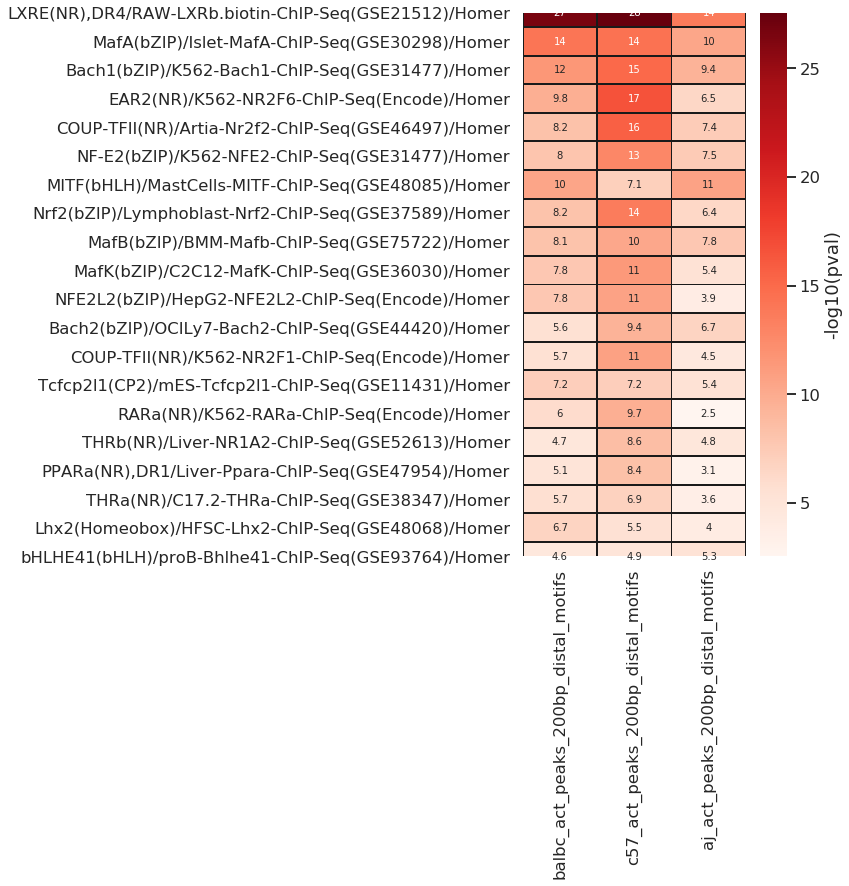

In [186]:
fig, ax = plt.subplots(figsize=(5,10))

sns.heatmap(
    -known_motif_pval_frame.loc[(known_motif_pval_frame <=np.log10(0.00001)).any(axis=1), :].head(20),
    cmap='Reds',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    # square=True,
    # center=0,
    ax=ax)

# Aggregate results - maggie

All enhancers

In [12]:
maggie_merged_pval_dict = {}
for f in glob.glob('./maggie_output/*/maggie_output_merged.tsv'):
    if 'balbc_aj' not in f:
        # read in signifance values using pandas
        frame = pd.read_csv(f, sep='\t', index_col=0)

        # remove duplicates
        # frame = frame[~frame.index.duplicated(keep='first')]
        pval = frame.loc[:, 'Median p-val']

        # extract name of sample
        sample = f.split('/')[2]

        # store in dict
        maggie_merged_pval_dict[sample] = pval    
    
# create data frame
maggie_merged_pval_frame = pd.DataFrame(maggie_merged_pval_dict)

# sort by average p value
maggie_merged_pval_frame = maggie_merged_pval_frame.reindex(maggie_merged_pval_frame.mean(axis=1).sort_values().index.tolist())

maggie_merged_pval_frame.to_csv('./maggie_all_merged_log.txt', sep='\t')

# filter for plotting
frame = maggie_merged_pval_frame

# select only samples with pval < 10-2
filtered_frame = frame.loc[(np.abs(frame) > 2).any(1), :]

# replace NaN with 0
# filtered_frame = filtered_frame.replace(np.nan, 0)

# sort
filtered_frame = filtered_frame.reindex(filtered_frame.mean(1).sort_values(ascending=False).index.tolist())

# fix index
filtered_frame.index = filtered_frame.index.str.split('$').str[0]

Plot top 30 motifs upregulated

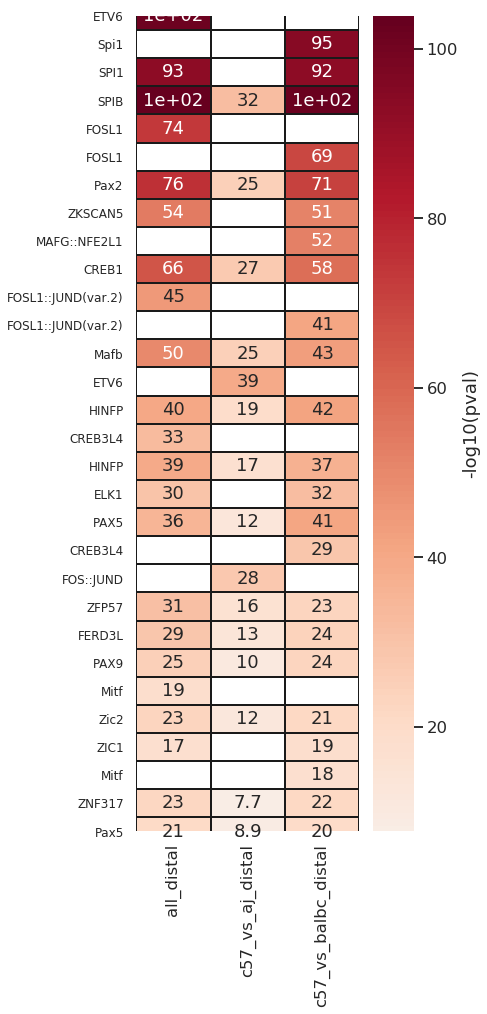

In [14]:
fig, ax = plt.subplots(figsize=(5,15))

hm = sns.heatmap(
    filtered_frame.loc[(filtered_frame.mean(1) > 0), :].iloc[:30, :],
    cmap='RdBu_r',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    # square=True,
    center=0,
    ax=ax)

hm.set_yticklabels(size=12, labels=filtered_frame.loc[(filtered_frame.mean(1) > 0), :].index.values, rotation=0);

plt.savefig('./figures/maggie_activated_motifs_merged.png', bbox_inches='tight')

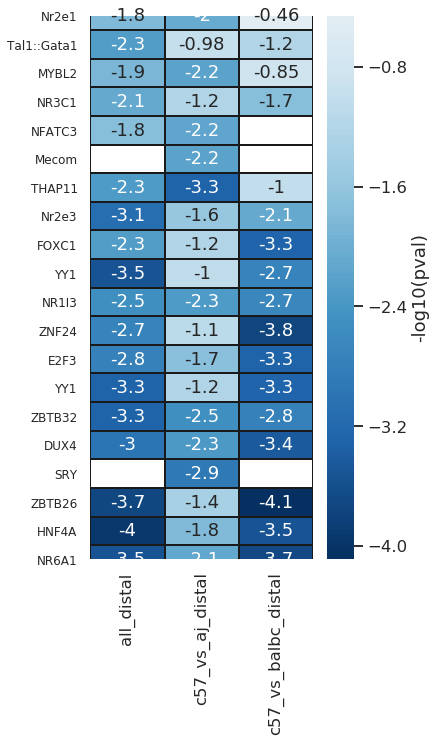

In [15]:
fig, ax = plt.subplots(figsize=(5,10))

hm = sns.heatmap(
    filtered_frame.loc[(filtered_frame.mean(1) < 0), :].iloc[:20, :],
    cmap='RdBu_r',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    # square=True,
    center=0,
    ax=ax)

hm.set_yticklabels(size=12,
                   labels=filtered_frame.loc[(filtered_frame.mean(1) < 0), :].index.values,
                   rotation=0);

plt.savefig('./figures/maggie_repressing_motifs_merged.png', bbox_inches='tight')

### Distal enhancers

In [18]:
maggie_merged_pval_dict = {}
for f in glob.glob('./maggie_output/*distal/maggie_output_merged.tsv'):
    if 'balbc_aj' not in f:
        # read in signifance values using pandas
        frame = pd.read_csv(f, sep='\t', index_col=0)

        # remove duplicates
        # frame = frame[~frame.index.duplicated(keep='first')]
        pval = frame.loc[:, 'Median p-val']

        # extract name of sample
        sample = f.split('/')[2]

        # store in dict
        maggie_merged_pval_dict[sample] = pval    
    
# create data frame
maggie_merged_pval_frame = pd.DataFrame(maggie_merged_pval_dict)

# sort by average p value
maggie_merged_pval_frame = maggie_merged_pval_frame.reindex(maggie_merged_pval_frame.mean(axis=1).sort_values().index.tolist())

maggie_merged_pval_frame.to_csv('./maggie_all_merged_log.txt', sep='\t')

# filter for plotting
frame = maggie_merged_pval_frame

# select only samples with pval < 10-2
# filtered_frame = frame.loc[(np.abs(frame) > 2).any(1), :]

# replace NaN with 0
filtered_frame = frame.replace(np.nan, 0)

# sort
filtered_frame = filtered_frame.reindex(filtered_frame.mean(1).sort_values(ascending=False).index.tolist())

# fix index
filtered_frame.index = filtered_frame.index.str.split('$').str[0]

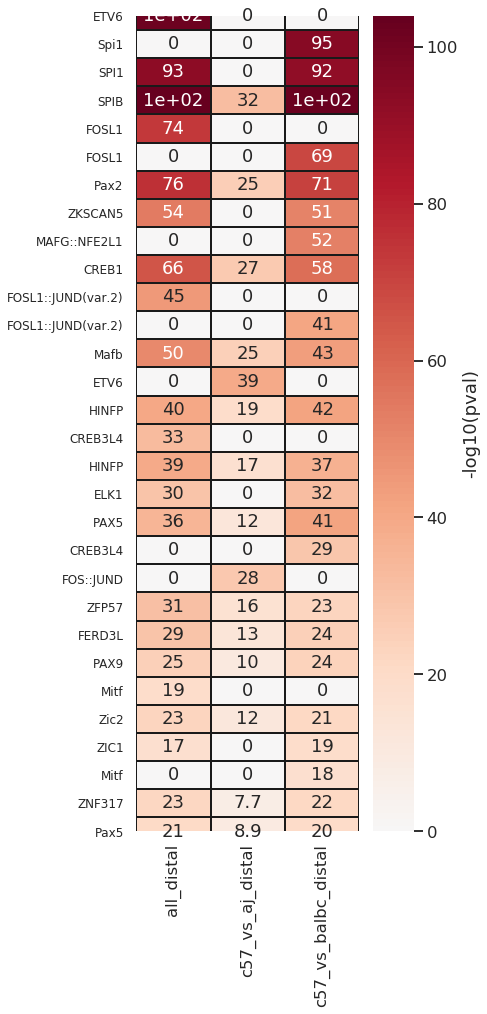

In [17]:
fig, ax = plt.subplots(figsize=(5,15))

hm = sns.heatmap(
    filtered_frame.loc[(filtered_frame.mean(1) > 0), :].iloc[:30, :],
    cmap='RdBu_r',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    # square=True,
    center=0,
    ax=ax)

hm.set_yticklabels(size=12, labels=filtered_frame.index.values, rotation=0);

plt.savefig('./figures/maggie_distal_activated_motifs_merged.png', bbox_inches='tight')

In [8]:
filtered_frame

,all_distal,c57_vs_aj_distal,c57_vs_balbc_distal
SPIB,103.89,31.86,102.59
ETV6,101.79,0.00,0.00
SPI1,93.25,0.00,92.43
Pax2,75.80,25.18,70.66
FOSL1,73.64,0.00,0.00
...,...,...,...
LIN54,-30.67,-13.72,-30.82
BARX2,-33.57,-13.88,-35.58
FOXL1,-36.32,-13.35,-36.11
ONECUT2,-41.28,0.00,0.00


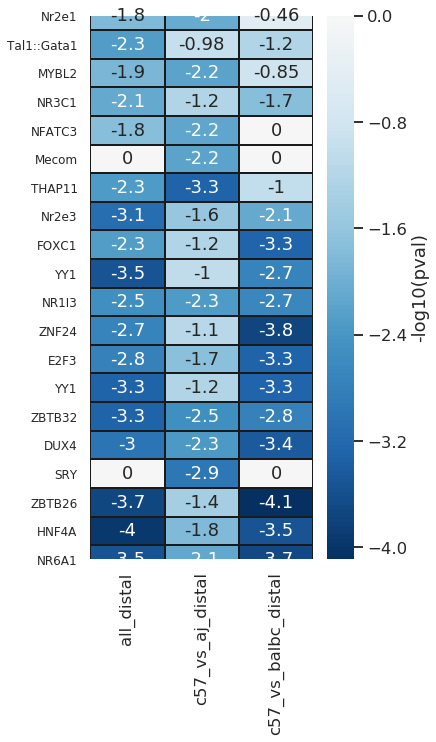

In [19]:
fig, ax = plt.subplots(figsize=(5,10))

hm = sns.heatmap(
    filtered_frame.loc[(filtered_frame.mean(1) < 0), :].iloc[:20, :],
    cmap='RdBu_r',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    # square=True,
    center=0,
    ax=ax)

hm.set_yticklabels(size=12, labels=filtered_frame.loc[(filtered_frame.mean(1) < 0), :].index.values, rotation=0);

plt.savefig('./figures/maggie_distal_repressed_motifs_merged.png', bbox_inches='tight')

### Plot with just the top motifs from c57_vs_all 

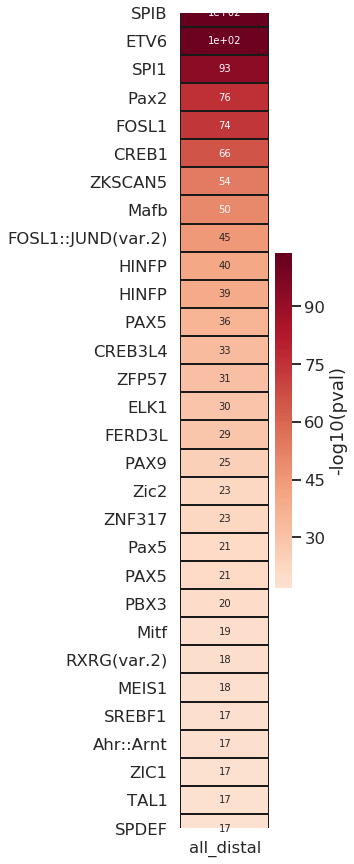

In [7]:
fig, ax = plt.subplots(figsize=(2,15))

filtered_frame = filtered_frame.sort_values('all_distal', ascending=False)

hm = sns.heatmap(
    filtered_frame.loc[:, ['all_distal']].iloc[:30, :],
    cmap='RdBu_r',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    # square=True,
    center=0,
    ax=ax)

# hm.set_yticklabels(size=12, labels=filtered_frame.index.values, rotation=0);

plt.savefig('./figures/maggie_distal_activated_motifs_merged_all.png', bbox_inches='tight')

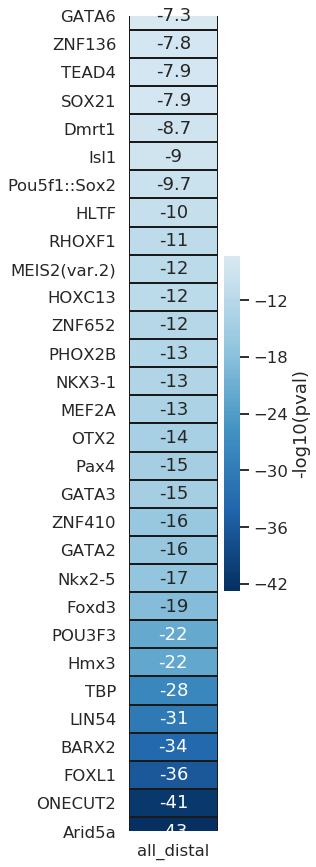

In [26]:
fig, ax = plt.subplots(figsize=(2,15))

filtered_frame = filtered_frame.sort_values('all_distal', ascending=False)

hm = sns.heatmap(
    filtered_frame.loc[:, ['all_distal']].tail(30),
    cmap='RdBu_r',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    # square=True,
    center=0,
    ax=ax)

# hm.set_yticklabels(size=12, labels=filtered_frame.index.values, rotation=0);

plt.savefig('./figures/maggie_distal_repressed_motifs_merged_all.png', bbox_inches='tight')

# Repeat with custom TFs

In [23]:
custom_tfs = ['SPIB', 'ETV6', 'SPI1', 'FOSL1', 'FOSL1::JUND(var.2)',
              'Mitf', 'RXRG(var.2)', 'SREBF1', 'NRF1', 'ATF4']

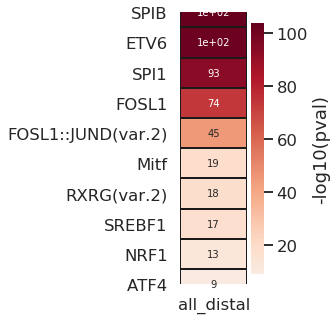

In [25]:
fig, ax = plt.subplots(figsize=(1.5,5))

tmp_frame = filtered_frame.sort_values('all_distal', ascending=False).iloc[:50, :]

hm = sns.heatmap(
    tmp_frame.loc[custom_tfs, ['all_distal']].iloc[:30, :],
    cmap='RdBu_r',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    # square=True,
    center=0,
    ax=ax)

# hm.set_yticklabels(size=12, labels=filtered_frame.index.values, rotation=0);

plt.savefig('./figures/maggie_distal_activated_motifs_merged_custom_tfs.pdf', bbox_inches='tight')

# Repressed enhancers

In [4]:
maggie_merged_pval_dict = {}
for f in glob.glob('./maggie_output/*rep/maggie_output_merged.tsv'):
    if 'balbc_aj' not in f:
        # read in signifance values using pandas
        frame = pd.read_csv(f, sep='\t', index_col=0)

        # remove duplicates
        # frame = frame[~frame.index.duplicated(keep='first')]
        pval = frame.loc[:, 'Median p-val']

        # extract name of sample
        sample = f.split('/')[2]

        # store in dict
        maggie_merged_pval_dict[sample] = pval    
    
# create data frame
maggie_merged_pval_frame = pd.DataFrame(maggie_merged_pval_dict)

# sort by average p value
maggie_merged_pval_frame = maggie_merged_pval_frame.reindex(maggie_merged_pval_frame.mean(axis=1).sort_values().index.tolist())

maggie_merged_pval_frame.to_csv('./maggie_all_merged_log.txt', sep='\t')

# filter for plotting
frame = maggie_merged_pval_frame

# select only samples with pval < 10-2
# filtered_frame = frame.loc[(np.abs(frame) > 2).any(1), :]

# replace NaN with 0
filtered_frame = frame.replace(np.nan, 0)

# sort
filtered_frame = filtered_frame.reindex(filtered_frame.mean(1).sort_values(ascending=False).index.tolist())

# fix index
filtered_frame.index = filtered_frame.index.str.split('$').str[0]

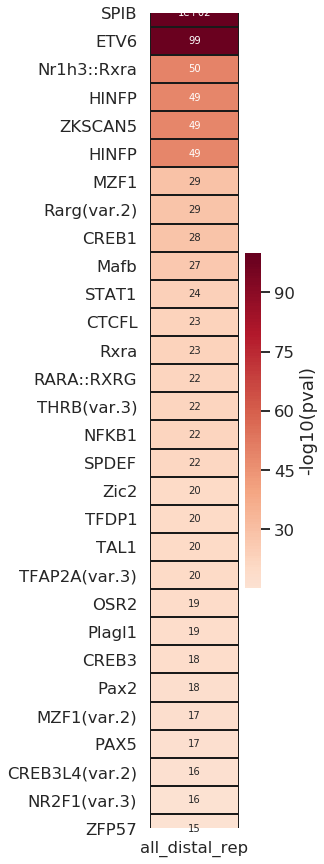

In [6]:
fig, ax = plt.subplots(figsize=(2,15))

filtered_frame = filtered_frame.sort_values('all_distal_rep', ascending=False)

hm = sns.heatmap(
    filtered_frame.loc[:, ['all_distal_rep']].iloc[:30, :],
    cmap='RdBu_r',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    # square=True,
    center=0,
    ax=ax)

# hm.set_yticklabels(size=12, labels=filtered_frame.index.values, rotation=0);

plt.savefig('./figures/maggie_distal_repressed_motifs_merged_all.png', bbox_inches='tight')

# repeat with  unmerged motifs

In [176]:
maggie_merged_pval_dict = {}
for f in glob.glob('./maggie_output/*c57*200bp/maggie_output.tsv'):
    if 'balbc_aj' not in f:
        # read in signifance values using pandas
        df = pd.read_csv(f, sep='\t', index_col=0)

        # remove duplicates
        # frame = frame[~frame.index.duplicated(keep='first')]
        pval = df.loc[:, 'Median p-val']

        # extract name of sample
        sample = f.split('/')[2]

        # store in dict
        maggie_merged_pval_dict[sample] = pval    
    
# create data frame
maggie_merged_pval_frame = pd.DataFrame(maggie_merged_pval_dict)

# sort by average p value
maggie_merged_pval_frame = maggie_merged_pval_frame.reindex(maggie_merged_pval_frame.mean(axis=1).sort_values().index.tolist())

maggie_merged_pval_frame.to_csv('./maggie_all_merged_log.txt', sep='\t')

# filter for plotting
frame = maggie_merged_pval_frame

# select only samples with pval < 10-10
filtered_frame = frame.loc[(np.abs(frame) > 20).any(1), :]

# replace NaN with 0
filtered_frame = filtered_frame.replace(np.nan, 0)

# sort
filtered_frame = filtered_frame.reindex(filtered_frame.mean(1).sort_values(ascending=False).index.tolist())

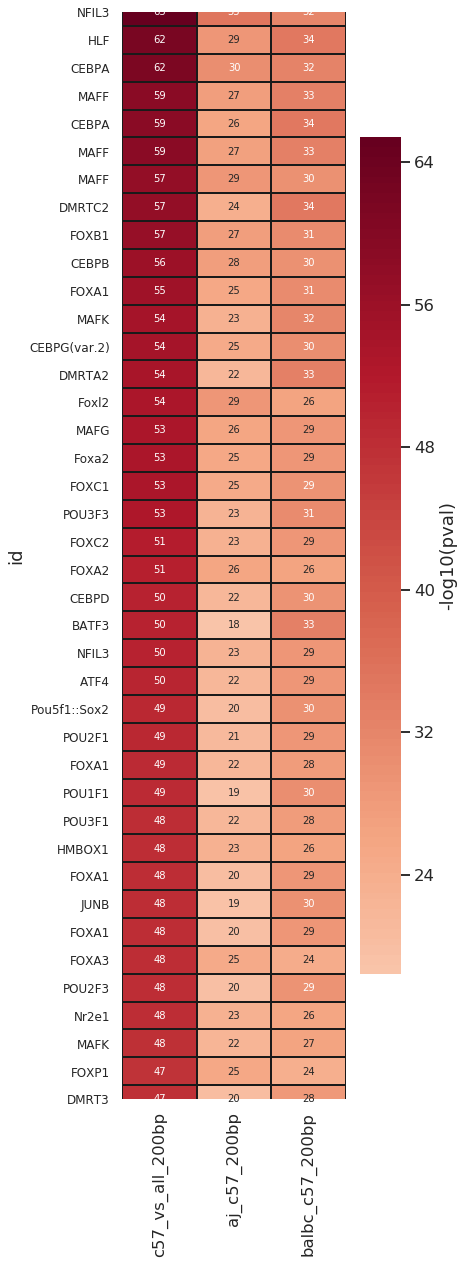

In [177]:
fig, ax = plt.subplots(figsize=(5,20))

hm = sns.heatmap(
    filtered_frame.loc[(filtered_frame.mean(1)) > 0, :].head(40),
    cmap='RdBu_r',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    # square=True,
    center=0,
    ax=ax)

hm.set_yticklabels(size=12, labels=df.loc[filtered_frame.index.values,'motif'], rotation=0);

plt.savefig('./figures/maggie_activated_motifs.png', bbox_inches='tight')

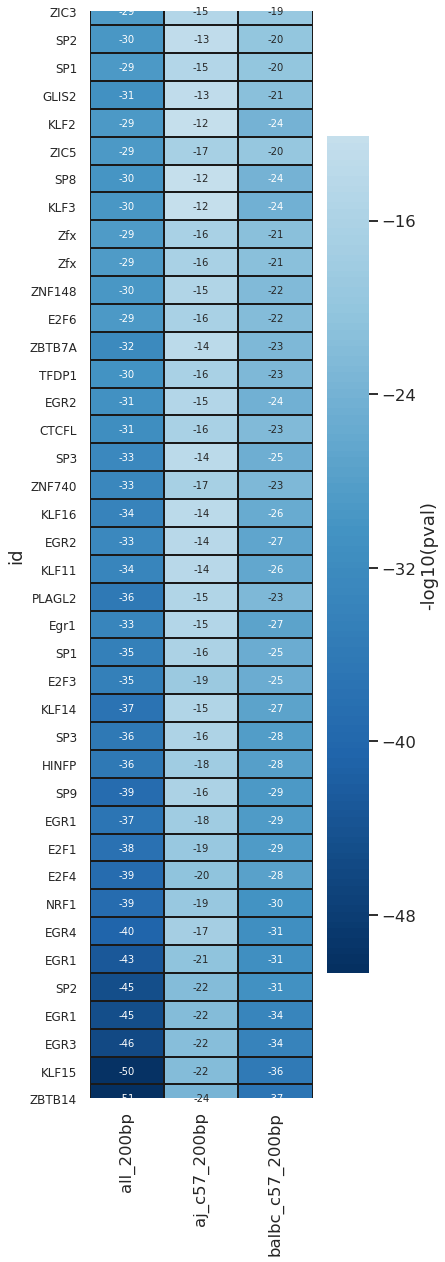

In [151]:
fig, ax = plt.subplots(figsize=(5,20))

hm = sns.heatmap(
    filtered_frame.loc[(filtered_frame.mean(1)) < 0, :].tail(40),
    cmap='RdBu_r',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    # square=True,
    center=0,
    ax=ax)

hm.set_yticklabels(size=12, labels=df.loc[filtered_frame.loc[(filtered_frame.mean(1)) < 0, :].tail(40).index.values,'motif'], rotation=0);

plt.savefig('./figures/maggie_repressed_motifs.png', bbox_inches='tight')

# Plot motifs

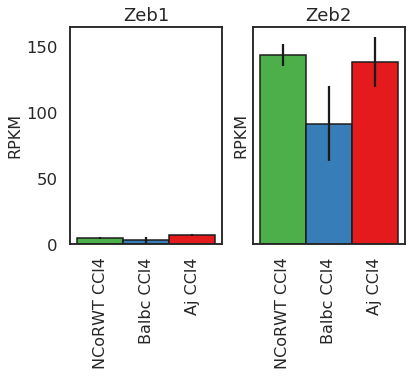

In [18]:
fig, axs = plt.subplots(1,2,figsize=(6,4), sharex=True, sharey=True)

count=0

for i in ['Zeb1', 'Zeb2']:
    survey_strain_ccl4_gene_exp(i, ax=axs.flatten()[count])
    count+=1

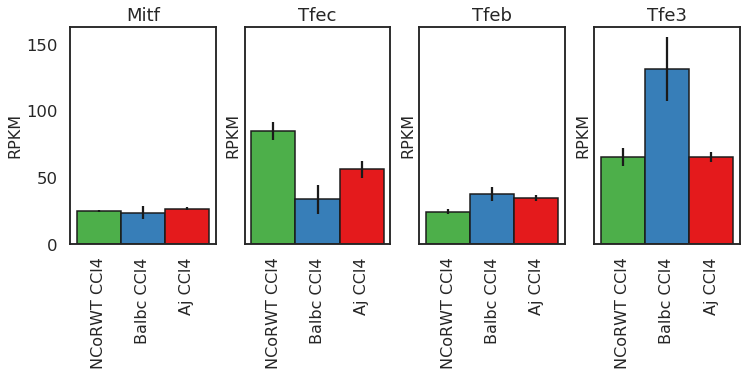

In [19]:
fig, axs = plt.subplots(1,4,figsize=(12,4), sharex=True, sharey=True)

count=0

for i in ['Mitf', 'Tfec', 'Tfeb', 'Tfe3']:
    survey_strain_ccl4_gene_exp(i, ax=axs.flatten()[count])
    count+=1

KeyError: 'Mzf2'

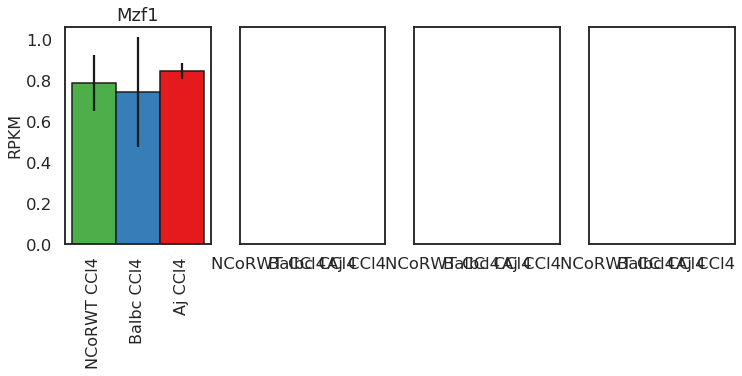

In [8]:
fig, axs = plt.subplots(1,4,figsize=(12,4), sharex=True, sharey=True)

count=0

for i in ['Mitf', 'Tfec', 'Tfeb', 'Tfe3']:
    survey_strain_ccl4_gene_exp(i, ax=axs.flatten()[count])
    count+=1